In [ ]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/KuangshiAi/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 49 (delta 6), reused 19 (delta 1), pack-reused 0
Unpacking objects: 100% (49/49), 1.86 MiB | 3.28 MiB/s, done.
Already up to date.


In [ ]:
!pip install -qr vision_transformer/vit_jax/requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.9/349.9 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 MB 4.3 MB/s eta 0:00:00


### Imports

In [ ]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [ ]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_16'  #@param ["ViT-B_16", "ViT-B_32", "ViT-B_16-224", "R50+ViT-B_16"]

#if model_name != 'ViT-B_16-224':
#  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
#if model_name == 'ViT-B_16-224':
![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

In [ ]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [ ]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [ ]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [ ]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [ ]:
dataset = 'imagenet_resized/64x64' #@param ["cifar10", "cifar100", "tf_flowers", "imagenet_resized/64x64"]
if dataset == 'imagenet_resized/64x64':
  imagenet_fix_factor = 5
else:
  imagenet_fix_factor = 1
batch_size = 256
config = common_config.with_dataset(common_config.get_config(), dataset)
config.batch = batch_size
config.pp.crop = 224

In [ ]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')

del config  # Only needed to instantiate datasets.

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imagenet_resized/64x64/0.1.0
INFO:absl:Load dataset info from /tmp/tmp9flmjw75tfds
INFO:absl:Fields info.[description, release_notes, config_name, config_description, citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset imagenet_resized (/root/tensorflow_datasets/imagenet_resized/64x64/0.1.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

INFO:absl:Downloading http://www.image-net.org/data/downsample//Imagenet64_train_part1_npz.zip into /root/tensorflow_datasets/downloads/image-net.org_downs_Image_train_part1_npzgHgDpRdBiZpNOu7WtyGmx__D1RsFxyG7HOISxgHTveY.zip.tmp.0f7f73dc11664c159270defc9f6baf1d...
INFO:absl:Downloading http://www.image-net.org/data/downsample//Imagenet64_train_part2_npz.zip into /root/tensorflow_datasets/downloads/image-net.org_downs_Image_train_part2_npzEq3eXJiZu5wgqizT3yKT_7UvIWbS9txoDkzvSqrPkVU.zip.tmp.16a8fd006ce14fdc93078fbe4f9ab253...
INFO:absl:Downloading http://www.image-net.org/data/downsample//Imagenet64_val_npz.zip into /root/tensorflow_datasets/downloads/image-net.org_downsampl_Imagenet6_val_npz4bJw8E6mWG1bJzFpEA4DtUVwtBfCtQUsUnSfTE21GEk.zip.tmp.8b83c1688d124b0d8d4ed7a454207f4f...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1281167 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0.incompleteMKLFVI/imagenet_resized-train.tfrec…

INFO:absl:Done writing /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0.incompleteMKLFVI/imagenet_resized-train.tfrecord*. Number of examples: 1281167 (shards: [10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10009, 10010, 10009, 10009, 10009, 

Generating validation examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0.incompleteMKLFVI/imagenet_resized-validation.…

INFO:absl:Done writing /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0.incompleteMKLFVI/imagenet_resized-validation.tfrecord*. Number of examples: 50000 (shards: [12500, 12500, 12500, 12500])


Dataset imagenet_resized downloaded and prepared to /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0. Subsequent calls will reuse this data.


INFO:absl:Constructing tf.data.Dataset imagenet_resized for split train[:8%], from /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0
INFO:absl:Reusing dataset imagenet_resized (/root/tensorflow_datasets/imagenet_resized/64x64/0.1.0)
INFO:absl:Constructing tf.data.Dataset imagenet_resized for split validation[:20%], from /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0


In [ ]:
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']

INFO:absl:Load dataset info from /root/tensorflow_datasets/imagenet_resized/64x64/0.1.0


In [ ]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(1, 512, 224, 224, 3)

### Load pre-trained

In [ ]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_16
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [ ]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [ ]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
INFO:absl:load_pretrained: drop-head variant


### Evaluate

In [ ]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (100,)
params_repl.cls: ArrayImpl (1, 100)


In [ ]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [ ]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  if dataset == 'imagenet_resized/64x64':
    fix_str = 'validation'
  elif dataset == 'tf_flowers':
    fix_str = 'train[80%:]'
  else:
    fix_str = 'test'
  steps = input_pipeline.get_dataset_info(dataset, fix_str)['num_examples'] // (batch_size * 2 * imagenet_fix_factor)
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [ ]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar100/3.0.2
100%|██████████| 19/19 [00:34<00:00,  1.82s/it]


Array(0.01027961, dtype=float32)

### Fine-tune

In [ ]:
# 100 epochs take approximately 5 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 10
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.001

In [ ]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [ ]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


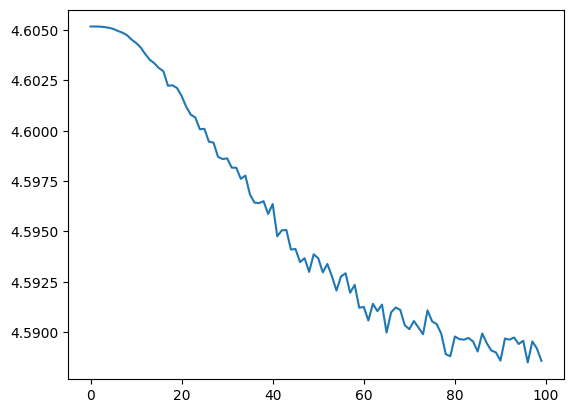

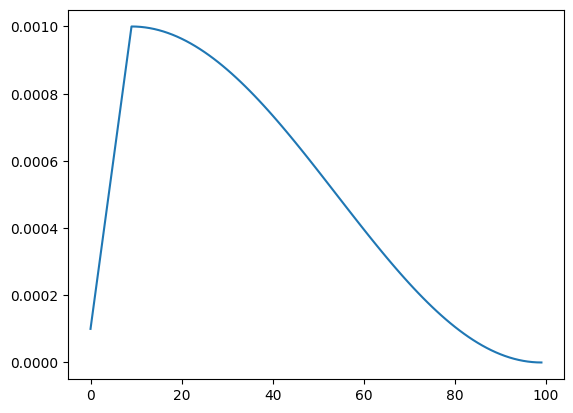

In [ ]:
losses = []
lrs = [] # learning rate scheduling
# Completes in 2 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [ ]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar100/3.0.2
100%|██████████| 19/19 [00:30<00:00,  1.60s/it]


Array(0.70641446, dtype=float32)